## 数据探索：电商订单数据的基本预处理

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Simhei'] 
plt.rcParams['axes.unicode_minus']=False

In [ ]:
data = pd.read_csv(r"H:\电商异常检测\abnormal_orders.txt")

In [ ]:
data.head() 

,order_id,order_date,order_time,cat,attribution,pro_id,pro_brand,total_money,total_quantity,order_source,pay_type,user_id,city,abnormal_label
0,4277880103,2013-10-17,13:09:16,NaN,GO,8000001215,NaN,1000.0,1000,游戏站点,当当支付,murongchun,北京市,0
1,4283851335,2013-09-23,14:09:49,手机摄影数码,POP,8002042497,三星,766000.0,200,主站,合并支付,dakehu_zy,上海市,1
2,4277700101,2013-08-27,14:26:38,NaN,GO,7000000960,国之美艺术品,8000.0,160,do.site_id,在线支付,1391175862,NaN,1
3,4276537082,2013-09-11,14:16:47,电视冰箱洗衣机空调,POP,8001992420,樱花,19900.0,100,主站,合并支付,qq-3be293b,泉州市,1
4,4281111595,2013-04-10,10:44:46,家具建材,POP,8002199518,纬度空间,100.0,100,主站,合并支付,nonscorpio,广州市,1


In [ ]:
data.columns

Index(['order_id', 'order_date', 'order_time', 'cat', 'attribution', 'pro_id',
       'pro_brand', 'total_money', 'total_quantity', 'order_source',
       'pay_type', 'user_id', 'city', 'abnormal_label'],
      dtype='object')

#### 查看样本数/特征数

In [ ]:
data.shape

(134190, 14)

#### 更换列名为中文

In [ ]:
data.columns = ["订单ID","下单日期","下单时间","商品一级类别","商品所属渠道","商品ID","品牌","订单金额","商品销售数量","订单渠道","支付方式","下单用户ID","城市","异常"]

In [ ]:
data.columns.tolist()

['订单ID',
 '下单日期',
 '下单时间',
 '商品一级类别',
 '商品所属渠道',
 '商品ID',
 '品牌',
 '订单金额',
 '商品销售数量',
 '订单渠道',
 '支付方式',
 '下单用户ID',
 '城市',
 '异常']

In [ ]:
data.head(5)

,订单ID,下单日期,下单时间,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,异常
0,4277880103,2013-10-17,13:09:16,NaN,GO,8000001215,NaN,1000.0,1000,游戏站点,当当支付,murongchun,北京市,0
1,4283851335,2013-09-23,14:09:49,手机摄影数码,POP,8002042497,三星,766000.0,200,主站,合并支付,dakehu_zy,上海市,1
2,4277700101,2013-08-27,14:26:38,NaN,GO,7000000960,国之美艺术品,8000.0,160,do.site_id,在线支付,1391175862,NaN,1
3,4276537082,2013-09-11,14:16:47,电视冰箱洗衣机空调,POP,8001992420,樱花,19900.0,100,主站,合并支付,qq-3be293b,泉州市,1
4,4281111595,2013-04-10,10:44:46,家具建材,POP,8002199518,纬度空间,100.0,100,主站,合并支付,nonscorpio,广州市,1


- 标签探索

In [ ]:
(data["异常"] == 1).sum()

28457

In [ ]:
(data["异常"] == 1).sum()/data.shape[0] #样本不均衡，但是不均衡的程度较轻

0.2120649824875177

- 下单时间

In [ ]:
data["下单日期"].value_counts()

2013-10-31    690
2013-03-21    429
2013-11-01    426
2013-01-24    422
2013-03-23    416
             ... 
2013-07-31     17
2013-08-31     14
2013-05-31      2
2013-03-31      2
2013-01-31      2
Name: 下单日期, Length: 364, dtype: int64

有364个类别，初步判断应该是覆盖2013年中每一天。如果是较大的电商平台，不太可能出现一天之内圈平台只有2单交易的情况，因此判断该数据应该是全年交易数据的抽样数据。

- 订单ID：订单号码

In [ ]:
#订单数据的ID一般不会有重复值，我们先确认一下ID是否是唯一ID
data["订单ID"].duplicated().sum()

19212

订单ID存在重复值，这对于我们的预测来说不是一个很好的消息。订单ID在电商系统中是不会复用的，一定是一单一号，因此重复的订单ID可能说明以下两个事实：
> - 数据中存在大量重复样本，需要删除
> - 数据中的每条样本并不是订单，反而可能是订单中的一个商品/一笔交易，因此标签中的异常实际上可能是“这笔交易的异常”，而非整个订单的异常情况（如果是这种情况，在数据预处理时将给我们带来无穷无尽的麻烦）

**标签很可能是交易异常，而非订单异常**。

- 商品一级类别

In [ ]:
data["商品一级类别"].value_counts()

手机摄影数码       20612
生活电器厨卫电器     19281
家纺寝居         18679
电脑办公打印文仪     11405
家居日用         10642
电视冰箱洗衣机空调     9067
美妆个护          9043
汽车用品          6490
家具建材          4941
食品酒水          4669
健康医疗          4252
服饰鞋帽          4067
运动户外          3934
母婴用品玩具        2664
箱包奢品          1962
钟表首饰           860
图书音像           232
Name: 商品一级类别, dtype: int64

In [ ]:
#高位的是电子产品、小型家电以及家纺，整个类别明显是带有部分家居/家电性质的商城的类别

- 商品所属渠道

In [ ]:
data["商品所属渠道"].value_counts()

GO     91170
POP    43020
Name: 商品所属渠道, dtype: int64

In [ ]:
(data["商品所属渠道"] == "GO").sum()/data.shape[0]

0.6794097920858484

从value_counts的结果来看商品所属渠道是商品供货/售卖的渠道<br><br>
**POP** - Platform Open Plan，平台开放计划 - 价值链整合模式中入驻的第三方/个人商家，货物来自第三方商家自己的供应商<br><br>
**GO** - 无法判断是何含义，但从订单占比来看，判断可能是价值链整合模式中的自营商家的品牌。这部分货物来自自营商家自己的供应商/厂房/工厂

- 订单渠道

In [ ]:
data["订单渠道"].value_counts()

主站            96894
抢购            16256
手机站点           7098
团购             6294
手机抢购           3095
do.site_id     2394
手机团购           1074
充值              703
当当              377
游戏站点              5
Name: 订单渠道, dtype: int64

交易实际发生的渠道/流量来源 - 不确定是可以在站外交易还是站外渠道引向主站进行交易。<br>
**大部分实际电商平台的订单是必须在平台内发生的**，渠道只是流量的渠道。<br>
大部分渠道看起来都简单明了，需要说明的是，渠道中的“手机站点”、“手机抢购”、“手机团购”等渠道都是指向移动端APP的营销方式，只不过当时还没有“移动端”这种名称。在渠道中，有三个渠道可以特别说明一下——<br>

**do.site_id**：在对外推广吸引流量时，每个推广位/媒体/推广者会有对应的ID，这个ID会方便渠道方管理自己的渠道，也会有利于推广者记录渠道的类型。

在淘宝的体系中，推广ID设计到三部分：Memberid（推广者ID），Siteid（媒体ID），Adzoneid（广告位ID），一个推广者可以在多个媒体上投放广告，而每个媒体也会有不同的广告位。

在这里，site_id应该指的就是对外推广的媒体ID，通常来说这个媒体可以包括短信推广、SEO推广、桌面弹窗广告、客户端内嵌广告、视频网站广告、其他站点广告等。通常来说这个id应该对应某个数字，但在这组数据中，site_id被用来指向外部媒体推广这种流量渠道。

**当当**：这两个渠道可能给我们一些关于数据来源的线索。当当与刚做电商时的亚马逊高度类似，一直以售卖图书闻名，在家电、家居、电子产品方面并无太多名声，为什么订单渠道中会有当当呢？

**充值**：充值是一个很特殊的业务，可能包括话费充值、QQ会员充值、游戏充值、点卡充值等等。今天，微信无缝接入手机话费充值业务，游戏基本都是F2P、APP内充值，我们很难从直觉上想到有许多充值业务的电商。但曾经有电商在2012、13年左右大规模提供过线上充值业务，那就是**国美电器**。

- 国美有充值业务的基因
> - 国美电器是家电零售连锁企业，早年在小家电、手机数码方面有很好的口碑。<br>
> - 在移动互联网全面兴起之前，手机充值业务基本由线下营业厅和线下售卖店包揽。<br>
> - 国美作为在手机数码方面有大量线下店的企业，天生就有手机充值业务的基因。因此当国美决定“上线”之后，线上充值业务也成为一块关键业务，顺带也上线了一些游戏充值业务。<br>
> - 时至今日，国美还有自己的线上游戏充值、手机充值中心。

- 国美与当当有合作历史
> - 2012年初，当当正面临京东的极速扩张，国美刚杀入电商领域，正是需要强强联合的时候。<br>
> - 同年4月，两家公司宣布合作，国美电器入驻当当商城，形成店中店，国美借用当当在互联网领域的流量，当当借用国美自带的生产供应链，试图通过线上线下结合的方式形成与京东抗衡的力量。<br>
> - 当然，这种策略在当时就不被市场看好，毕竟光靠拓展一个不以家电闻名的渠道，其实并不能提高太多的效率。同时，在合作过程中双方都没有展现出开放的心态和魄力，导致这种合作停留在了浅尝辄止的阶段。<br>
> - 时至今日，当当依然在售卖部分3C产品，但国美与当当的合作已有些“名存实亡”之感。<br>

大量充值业务以及作为渠道的“当当”不禁让我们推测，**这份数据是国美线上店2013年全年交易数据的抽样**，那刚才商品所属渠道中无法理解的“GO”就能解释得通了，作为价值链整合模式中的自营商家的品牌，GO是国美GOME的简称。

- 支付方式

In [ ]:
data["支付方式"].value_counts()

合并支付    104274
货到付款     26785
当当支付      2511
在线支付       421
账户余额       199
Name: 支付方式, dtype: int64

> - 合并支付 - 购物车支付
> - 货到付款 - 许多价值链整合模式的平台会对自营店开放货到付款服务，京东在早期就提供大量的货到付款服务
> - 在线支付 - 可能覆盖支付宝、微信等其他支付方式

- 城市

In [ ]:
data["城市"].value_counts()

北京市        14554
上海市         6637
广州市         6033
深圳市         5468
天津市         3393
           ...  
昌都地区           1
江西省其他城市        1
山东省其他城市        1
云南省其他城市        1
四川省其他城市        1
Name: 城市, Length: 365, dtype: int64

由于数据是平台提供的，很可能是商品发货的城市，但从北上广深为订单最多的前四名城市来看，该城市更可能是订单的收货地址所在的城市，或下单IP所在城市。可以说，直到拼多多诞生之前，大部分电商平台服务的核心用户还是一线城市及一线城市周边的城市群。

#### 查看数据的其他信息，包括索引类型/数据类型/数据大小等

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134190 entries, 0 to 134189
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   订单ID    134190 non-null  int64  
 1   下单日期    134190 non-null  object 
 2   下单时间    134190 non-null  object 
 3   商品一级类别  132800 non-null  object 
 4   商品所属渠道  134190 non-null  object 
 5   商品ID    134190 non-null  int64  
 6   品牌      133418 non-null  object 
 7   订单金额    134189 non-null  float64
 8   商品销售数量  134190 non-null  int64  
 9   订单渠道    134190 non-null  object 
 10  支付方式    134190 non-null  object 
 11  下单用户ID  134190 non-null  object 
 12  城市      134188 non-null  object 
 13  异常      134190 non-null  int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 14.3+ MB


- 数据量为13w，是有一定规模的数据，但大部分计算机运行应该没问题
- 粗略看来，部分特征存在缺失值
- 几乎所有有效特征都是object类型，有较大的数据预处理空间
- 唯一的浮点数类型特征是订单金额，整数型特征基本没用——

In [ ]:
data.select_dtypes(include="int64").head()

,订单ID,商品ID,商品销售数量,异常
0,4277880103,8000001215,1000,0
1,4283851335,8002042497,200,1
2,4277700101,7000000960,160,1
3,4276537082,8001992420,100,1
4,4281111595,8002199518,100,1


异常订单是标签，订单ID与产品ID原则上都是离散型变量，不能以数值方式直接带入进行建模，商品销售数量虽然原则上是离散型变量，实际却可以当做连续型来处理。

### 2. 缺失值处理：信息缺失与异常有关吗？

In [ ]:
data.isnull().sum()

订单ID         0
下单日期         0
下单时间         0
商品一级类别    1390
商品所属渠道       0
商品ID         0
品牌         772
订单金额         1
商品销售数量       0
订单渠道         0
支付方式         0
下单用户ID       0
城市           2
异常           0
dtype: int64

In [ ]:
data.isnull().sum()*100/data.shape[0]

订单ID      0.000000
下单日期      0.000000
下单时间      0.000000
商品一级类别    1.035845
商品所属渠道    0.000000
商品ID      0.000000
品牌        0.575304
订单金额      0.000745
商品销售数量    0.000000
订单渠道      0.000000
支付方式      0.000000
下单用户ID    0.000000
城市        0.001490
异常        0.000000
dtype: float64

有缺失值，但缺失值比例非常小，其中城市与订单金额分别有1、2个缺失，完全可以忽略不计。在商质量参差不齐的电商领域，品牌信息缺失并不值得注意，稍微调查一下“商品一级类别”中缺失的情况即可。

“商品一级类别”缺失了1.03%。通常来说这个比例的缺失样本都可以直接删除，但考虑到电商行业在业务上对“异常”的定义，关键信息的缺失或许与“交易异常”有联系。

我们有许多种手段来判断缺失与交易异常之间的联系：

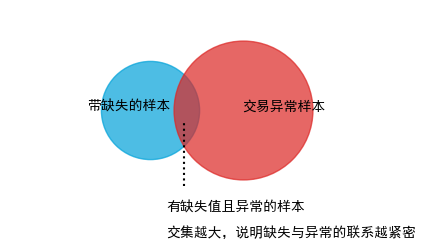

In [ ]:
plt.rcParams['font.sans-serif']=['Simhei'] 
plt.rcParams['axes.unicode_minus']=False

plt.figure(figsize=(5,3), dpi=100)
plt.scatter(2.8,5,s=5000,c="#01a2d9",alpha=0.7,label="带缺失的样本")
plt.scatter(4,5,s=10000,c="#dc2624",alpha=0.7,label="交易异常样本")
plt.xlim(1,6)
plt.ylim(2.5,7)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.text(2,5,s="带缺失的样本",fontsize=10)
plt.text(4,5,s="交易异常样本",fontsize=10)
plt.vlines(3.25,3.5,4.8,colors="k",linestyles="dotted")
plt.text(3.015,3,s="有缺失值且异常的样本",fontsize=10)
plt.text(3.015,2.5,s="交集越大，说明缺失与异常的联系越紧密",fontsize=10)
plt.xticks([])
plt.yticks([])
plt.show()

- 检查交集/全部带缺失样本的比例
- 该比例很高则说明带缺失的样本基本都是交易异常，缺失本身与交易异常的联系很强

In [ ]:
for i in ["商品一级类别","品牌"]:
    ratio1 = 100*data.loc[data[i].isnull(),"异常"].sum()/data[i].isnull().sum()
    print("缺少（{}）的样本中异常样本占比为{:.3f}%".format(i,ratio1))

缺少（商品一级类别）的样本中异常样本占比为11.727%
缺少（品牌）的样本中异常样本占比为20.984%


该数值说明，**商品并不会因为缺少品牌信息或缺少商品信息就被判断为交易异常**。缺失与交易异常的联系并不大。

- 检查交集/全部交易异常样本的比例
- 该比例很高则说明带缺失样本占据了很大的标签比例，不能轻易删除

In [ ]:
for i in ["商品一级类别","品牌"]:
    ratio2 = 100*data.loc[data[i].isnull(),"异常"].sum()/(data["异常"]==1).sum()
    print("全部交易异常样本中，缺少（{}）的异常样本占比为{:.3f}%".format(i,ratio2))

全部交易异常样本中，缺少（商品一级类别）的异常样本占比为0.573%
全部交易异常样本中，缺少（品牌）的异常样本占比为0.569%


该数值说明，**全部交易异常样本中，缺失样本的占比非常小**，可以直接删除处理。

In [ ]:
data.dropna(how="any",inplace=True)

In [ ]:
data.info() #不再具有任何缺失值

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132761 entries, 1 to 134189
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   订单ID    132761 non-null  int64  
 1   下单日期    132761 non-null  object 
 2   下单时间    132761 non-null  object 
 3   商品一级类别  132761 non-null  object 
 4   商品所属渠道  132761 non-null  object 
 5   商品ID    132761 non-null  int64  
 6   品牌      132761 non-null  object 
 7   订单金额    132761 non-null  float64
 8   商品销售数量  132761 non-null  int64  
 9   订单渠道    132761 non-null  object 
 10  支付方式    132761 non-null  object 
 11  下单用户ID  132761 non-null  object 
 12  城市      132761 non-null  object 
 13  异常      132761 non-null  int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 15.2+ MB


删除样本后，需重新整理索引：

In [ ]:
data.index = range(data.shape[0])

确认现在的样本数量与异常订单数量：

In [ ]:
data.shape[0]

132761

In [ ]:
(data["异常"] == 1).sum()

28284

### 3. 重复值处理：订单重复背后隐藏的问题

In [ ]:
data["订单ID"].duplicated().sum()

18554

记得之前我们查看过“订单ID”，发现订单ID是有重复的，因此整个数据集中含有重复样本的可能性很高，并且样本很可能不是订单，而是订单中的一个商品、一次交易。我们来看看——

In [ ]:
data.duplicated().sum() #只有8条重复样本，直接删除

8

In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
data.shape

(132753, 14)

现在来看，每个样本大概率是订单中的不同商品。

In [ ]:
data["订单ID"].value_counts()

4279118253    32
4269390206    23
4271884108    20
4275856215    20
4265415474    19
              ..
4279111697     1
4280944658     1
4284934145     1
4283578388     1
4285530112     1
Name: 订单ID, Length: 114207, dtype: int64

随机选择一个重复订单，进行查看：

In [ ]:
data[data["订单ID"] == 4279118253].head(10)

,订单ID,下单日期,下单时间,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,异常
95213,4279118253,2013-07-23,23:22:21,家具建材,GO,1000147804,西门子,10.6,1,主站,合并支付,cxh0111,湛江市,0
95214,4279118253,2013-11-08,23:22:21,家具建材,GO,1000147804,西门子,10.6,1,主站,合并支付,cxh0111,湛江市,0
95215,4279118253,2013-01-26,23:22:21,家具建材,GO,1000147606,西门子,20.6,1,主站,合并支付,cxh0111,湛江市,0
95216,4279118253,2013-02-03,23:22:21,家具建材,GO,1000147606,西门子,20.6,1,主站,合并支付,cxh0111,湛江市,0
95217,4279118253,2013-07-06,23:22:21,家具建材,GO,1000147606,西门子,20.6,1,主站,合并支付,cxh0111,湛江市,0
95218,4279118253,2013-04-28,23:22:21,家具建材,GO,1000147826,西门子,10.6,1,主站,合并支付,cxh0111,湛江市,0
95219,4279118253,2013-10-04,23:22:21,家具建材,GO,1000147826,西门子,10.6,1,主站,合并支付,cxh0111,湛江市,0
95220,4279118253,2013-02-21,23:22:21,家具建材,GO,1000147826,西门子,10.6,1,主站,合并支付,cxh0111,湛江市,0
95221,4279118253,2013-06-18,23:22:21,家具建材,GO,1000147826,西门子,10.6,1,主站,合并支付,cxh0111,湛江市,0
95222,4279118253,2013-09-25,23:22:21,家具建材,GO,1000147826,西门子,10.6,1,主站,合并支付,cxh0111,湛江市,0


诡异的事情发生了，同一个订单ID下有相同的产品，并且全部是同一个用户、同一个地址在**不同日期的同一时间下单**的商品。同一订单下有相同的产品可以理解为购买了多件该产品、且每件都被记为了一个样本，但**一个用户在不同日期的同一时间下单，还形成了同样的订单ID，这明显是人为捏造的交易或数据有误。**通常来说，即便是设置好规律的自动下单（企业采购时可能会有如此情况），也不太可能实现交易时间在时分秒上完全一致，何况这些交易的金额非常小，完全不像企业订单。

In [ ]:
data[data["订单ID"] == 4269390206].head(10)

,订单ID,下单日期,下单时间,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,异常
76916,4269390206,2013-09-26,02:11:10,电视冰箱洗衣机空调,GO,1000324051,夏普,2588.0,1,主站,合并支付,1390109546,西安市,0
76917,4269390206,2013-03-09,02:11:10,电视冰箱洗衣机空调,POP,8002267703,夏普,14999.0,1,主站,合并支付,1390109546,西安市,0
76918,4269390206,2013-09-21,02:11:10,电视冰箱洗衣机空调,GO,1000324052,夏普,3888.0,1,主站,合并支付,1390109546,西安市,0
76919,4269390206,2013-01-23,02:11:10,家居日用,GO,1000174960,伟经,275.0,1,主站,合并支付,1390109546,西安市,0
76920,4269390206,2013-11-12,02:11:10,电脑办公打印文仪,GO,1000315933,中亿,738.0,1,主站,合并支付,1390109546,西安市,0
76921,4269390206,2013-05-03,02:11:10,生活电器厨卫电器,GO,1000320932,凯伍德,1690.0,1,主站,合并支付,1390109546,西安市,0
76922,4269390206,2013-05-02,02:11:10,家居日用,GO,1000336076,康宁,439.0,1,主站,合并支付,1390109546,西安市,0
76923,4269390206,2013-12-19,02:11:10,家居日用,GO,1000192284,国研联合,158.0,1,主站,合并支付,1390109546,西安市,0
76924,4269390206,2013-10-28,02:11:10,家居日用,GO,1000104751,苏泊尔,459.0,1,主站,合并支付,1390109546,西安市,0
76925,4269390206,2013-12-05,02:11:10,家居日用,GO,1000104746,苏泊尔,229.0,1,主站,合并支付,1390109546,西安市,0


查看另一个订单ID，也是相似的情况。我们基本可以判断，其中许多订单是人为加上日期再捏造的，**有人复制了订单或商品交易信息，再赋予不同的日期，对数据进行伪造**。这有可能是为了算法建模而做的数据增强，因此我们需要进一步查看，这些人造信息是否大量覆盖了交易异常的订单。

In [ ]:
DupOrder = data["订单ID"].value_counts().index #找出重复订单的索引

In [ ]:
#查看重复订单ID下，异常订单的情况
for i in DupOrder[:30]:
    AbOrder = (data.loc[data["订单ID"] == i,"异常"]==1).sum()
    print(i,":",AbOrder)

4279118253 : 0
4269390206 : 0
4271884108 : 20
4275856215 : 20
4265415474 : 0
4279551124 : 0
4283339603 : 0
4283339890 : 0
4283336310 : 0
4283873538 : 0
4283339774 : 0
4283874524 : 0
4283874688 : 0
4283874398 : 0
4283874209 : 0
4283873946 : 0
4276167340 : 0
4282513806 : 0
4282561933 : 0
4282842151 : 0
4193043860 : 16
4282512627 : 0
4282513764 : 0
4272509367 : 0
4282842230 : 0
4282842130 : 0
4282842193 : 0
4282842612 : 0
3826438122 : 0
4285070202 : 0


In [ ]:
data[data["订单ID"] == 4271884108].head()

,订单ID,下单日期,下单时间,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,异常
3980,4271884108,2013-04-30,09:41:31,服饰鞋帽,POP,8002089657,PPZ,178.0,2,手机站点,合并支付,gome_taozx,广州市,1
3981,4271884108,2013-10-09,09:41:31,服饰鞋帽,POP,8000345913,漫路,176.0,2,手机站点,合并支付,gome_taozx,广州市,1
15817,4271884108,2013-09-06,09:41:31,服饰鞋帽,POP,8002287340,jstfe,49.0,1,手机站点,合并支付,gome_taozx,广州市,1
15818,4271884108,2013-09-30,09:41:31,服饰鞋帽,POP,8002287341,jstfe,49.0,1,手机站点,合并支付,gome_taozx,广州市,1
15819,4271884108,2013-09-16,09:41:31,服饰鞋帽,POP,8002206973,梵利玛,109.0,1,手机站点,合并支付,gome_taozx,广州市,1


In [ ]:
#一个订单ID下的产品ID有重复吗？
data.loc[data["订单ID"] == 4271884108,"商品ID"].duplicated().sum()

0

In [ ]:
data[data["订单ID"] == 4193043860].head()

,订单ID,下单日期,下单时间,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,异常
1118,4193043860,2013-06-23,22:50:54,生活电器厨卫电器,POP,8000325989,飞利浦,690.0,5,主站,合并支付,ye519888,惠州市,1
3794,4193043860,2013-07-19,22:50:54,生活电器厨卫电器,GO,1000365248,飞利浦,334.0,2,主站,合并支付,ye519888,惠州市,1
11939,4193043860,2013-01-05,22:50:54,手机摄影数码,GO,1000366925,华为,2288.0,1,主站,合并支付,ye519888,惠州市,1
11940,4193043860,2013-02-02,22:50:54,生活电器厨卫电器,GO,1000308290,奔腾,68.0,1,主站,合并支付,ye519888,惠州市,1
11941,4193043860,2013-08-27,22:50:54,生活电器厨卫电器,GO,1000310218,飞利浦,228.0,1,主站,合并支付,ye519888,惠州市,1


In [ ]:
#再次，一个订单ID下的产品重复情况
data.loc[data["订单ID"] == 4193043860,"商品ID"].duplicated().sum()

0

我们可以发现：
- 同一订单ID下总是出现“不同日期同一时间”下单的情况，许多样本的“日期”特征很都是伪造的
- 对异常样本来说，订单下的商品ID都是不同的，并没有出现同一个订单下出现了相同商品的情况。这说明异常样本的下单时间虽然也是伪造的，但是样本本身并没有被伪造。

从建模角度来说，这种方式增加样本权重意义不大，因此**我们需要剔除“下单日期”这个特征后再进行去重**。同一订单下ID下，只要商品/价格有任意的区别，我们都可以认为样本是真实的交易，而不是人造的数据。如果去重之后，异常样本的数量没有变化，就说明异常样本中并没有人造样本。

去重之前的异常订单数量：

In [ ]:
(data["异常"] == 1).sum()

28284

In [ ]:
data2 = data.drop(columns="下单日期")

In [ ]:
data2.duplicated().sum() #幸运的是这个数值很小，说明人造的数据并不太多

1471

In [ ]:
#取出重复值的索引，按索引进行删除

In [ ]:
data.drop(index=data[data2.duplicated()].index,inplace=True)

In [ ]:
data["订单ID"].value_counts()

4269390206    23
4275856215    20
4271884108    20
4265415474    19
4283336310    18
              ..
4284571775     1
4284913792     1
4242454660     1
4178489477     1
4285530112     1
Name: 订单ID, Length: 114207, dtype: int64

In [ ]:
#再提取其中一个订单ID进行查看，已经没有同一个订单下相同产品的情况了
data[data["订单ID"] == 4269390206].head()

,订单ID,下单日期,下单时间,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,异常
76916,4269390206,2013-09-26,02:11:10,电视冰箱洗衣机空调,GO,1000324051,夏普,2588.0,1,主站,合并支付,1390109546,西安市,0
76917,4269390206,2013-03-09,02:11:10,电视冰箱洗衣机空调,POP,8002267703,夏普,14999.0,1,主站,合并支付,1390109546,西安市,0
76918,4269390206,2013-09-21,02:11:10,电视冰箱洗衣机空调,GO,1000324052,夏普,3888.0,1,主站,合并支付,1390109546,西安市,0
76919,4269390206,2013-01-23,02:11:10,家居日用,GO,1000174960,伟经,275.0,1,主站,合并支付,1390109546,西安市,0
76920,4269390206,2013-11-12,02:11:10,电脑办公打印文仪,GO,1000315933,中亿,738.0,1,主站,合并支付,1390109546,西安市,0


删除样本后，需重新整理索引：

In [ ]:
data.index = range(data.shape[0])

确认剩余的异常订单的数量：

In [ ]:
(data["异常"] == 1).sum()

28284

这说明我们的推测是正确的，异常订单中并没有人造的部分。其他的“人造订单”很可能是放出该份数据的人员人为增加的。

另外，你是否发现了一个现象？
- **任意订单ID下，所有样本的标签是一致的**

In [ ]:
#有异常的订单
data.loc[data["异常"]==1,"订单ID"].value_counts()

4275856215    20
4271884108    20
4193043860    16
4272902282    15
4263198458    14
              ..
4282488931     1
4261577594     1
3982046076     1
4276053188     1
4196075521     1
Name: 订单ID, Length: 25107, dtype: int64

In [ ]:
data.loc[data["订单ID"] == 4263198458,"异常"]

1560     1
3931     1
3932     1
14800    1
14801    1
14802    1
14803    1
14804    1
14805    1
14806    1
14807    1
14808    1
14809    1
14810    1
Name: 异常, dtype: int64

In [ ]:
#无异常的订单
data.loc[data["异常"]!=1,"订单ID"].value_counts()

4269390206    23
4265415474    19
4283874524    18
4283874209    18
4283339603    18
              ..
4216566879     1
4174660705     1
4032975971     1
4282231846     1
4123656192     1
Name: 订单ID, Length: 89105, dtype: int64

In [ ]:
data.loc[data["订单ID"] == 4269390206,"异常"].sum()

0

我们可以在整个数据集上验证一下这一点。对每个含有交易异常样本的订单ID，我们计算该【ID下异常样本】占该【ID下全部样本的比例】。

In [ ]:
label_1 = data.loc[data["异常"]==1,"订单ID"].value_counts()

In [ ]:
###=====【TIME WARNING: 3mins】=====###
df = pd.DataFrame()
for idx,i in enumerate(label_1.index):
    ratio = label_1[i]/data[data["订单ID"] == i].shape[0]
    df.loc[idx,"订单ID"] = i
    df.loc[idx,"该ID下交易异常样本占所有样本的比例"] = ratio

In [ ]:
df["该ID下交易异常样本占所有样本的比例"].value_counts()

1.0    25102
0.5        5
Name: 该ID下交易异常样本占所有样本的比例, dtype: int64

我们的观察几乎是正确的，这说明如果一个订单ID下的所有样本的标签几乎是一致的。在之后进行预测时我们可以利用这一点修正预测标签。

在之前的探索中，我们注意到下单日期这个特征很可能是被捏造的，在进行建模时，我们不能让不符合业务逻辑的被带入模型，因此我们必须修正该特征。现在的问题是：所有的下单日期都是人造的吗，还是只有相同订单ID下的不同日期是人造的？从业务和人心的角度来考虑，我认为**整个下单日期特征都是人造的**，主要是因为下单日期的分布过于均匀：

In [ ]:
#先来看现在每个月的交易量分布
OrderMonth = data["下单日期"].apply(lambda x: x[5:7])
OrderMonth.value_counts()

10    11651
06    11201
09    11124
03    11113
07    11011
01    10959
04    10912
05    10888
12    10842
08    10837
11    10723
02    10021
Name: 下单日期, dtype: int64

通常来说，当一个订单被拆分成多比交易、且交易的日期各不相同时，**这个订单的实际下单日期很可能该订单ID下所有交易日期中最早的那个日期**。因为订单至少要在某一个日期实际发生，当人为在一个订单上制造日期时，通常不会倾向于去制造一个比实际交易日期还早的日期。

因此，在一部分订单日期是真实的、另一部分订单日期是人为制造的情况下，越往后的月份订单交易量会倾向于越多，而不会像现在看到的一样分布均匀。唯一的可能就是整个下单日期特征都是人造的，并且是故意制造成均匀分布在1-12月的状态。通常来说，异常与否都与交易时间没有太大的关联，现在我们还高度怀疑下单日期这个特征的数据可靠性，因此我们可以直接删除“下单日期”这个特征。

那如果我们还想要继续保留这个特征，要怎么办呢？我会建议取一个订单ID下所有样本的下单日期的中位数，来覆盖全部样本下的下单日期，这样可以保留原本在1-12月均匀的交易量分布。无论如何，如果要保留日期特征，则必须保证一个订单下所有样本的下单日期都一致。

In [ ]:
data.drop(columns="下单日期",inplace=True)

### 4. 异常值：特征异常与交易异常有关吗？

- 先查看数据的分布与统计

对于大部分数，分布和统计能够帮助我们快速理解特征的部分情况，但现在的数据中有且只有交易金额、交易数量这两个连续型特征，且许多离散型特征的“分布”对当下的预测并无太大意义（如品牌、商品一级类别、城市），因此我们只对两个连续型特征做统计。

In [ ]:
data.columns

Index(['订单ID', '下单时间', '商品一级类别', '商品所属渠道', '商品ID', '品牌', '订单金额', '商品销售数量',
       '订单渠道', '支付方式', '下单用户ID', '城市', '异常'],
      dtype='object')

In [ ]:
data.loc[:,["订单金额","商品销售数量"]].describe()

,订单金额,商品销售数量
count,131282.000000,131282.000000
mean,667.187834,1.188975
std,2930.730828,1.684653
min,0.500000,1.000000
25%,29.000000,1.000000
50%,98.000000,1.000000
75%,379.000000,1.000000
max,766000.000000,200.000000


确认没有小于0的业务上不该出现的异常值，从分布来看两个连续型变量都可能出现大量的异常。

In [ ]:
#使用seaborn绘制分布图

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 35746 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 21333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 37329 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 39069 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 27010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 29575 missing from c

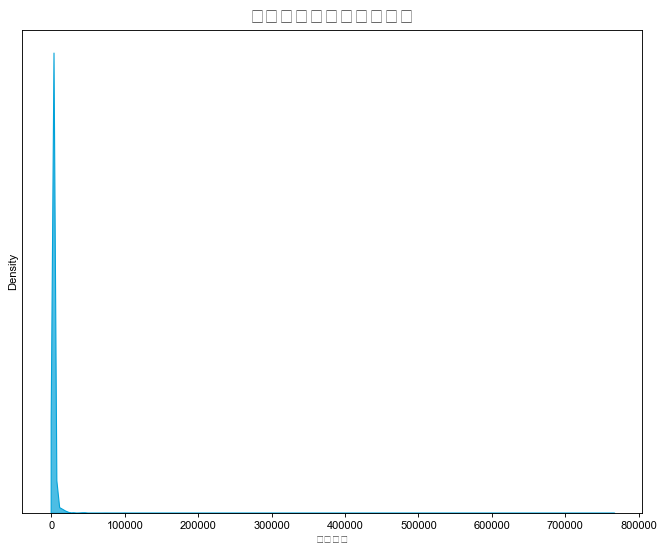

In [ ]:
import seaborn as sns
plt.rcParams['font.sans-serif']=['Simhei'] #让jupyter中的图画上的中文都显示出来
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(10, 8), dpi=80)
#绘图
sns.kdeplot(data.loc[:, "订单金额"],
            shade=True,
            color="#01a2d9",
            label="订单金额",
            alpha=.7)
#风格与装饰
sns.set(style="whitegrid",font="simhei", font_scale=1.1)
plt.title("订单金额概率密度分布图",fontsize=18)
plt.yticks([])
#plt.xlim((-10000,100000))
#plt.xlim((-1,10000))
plt.show()

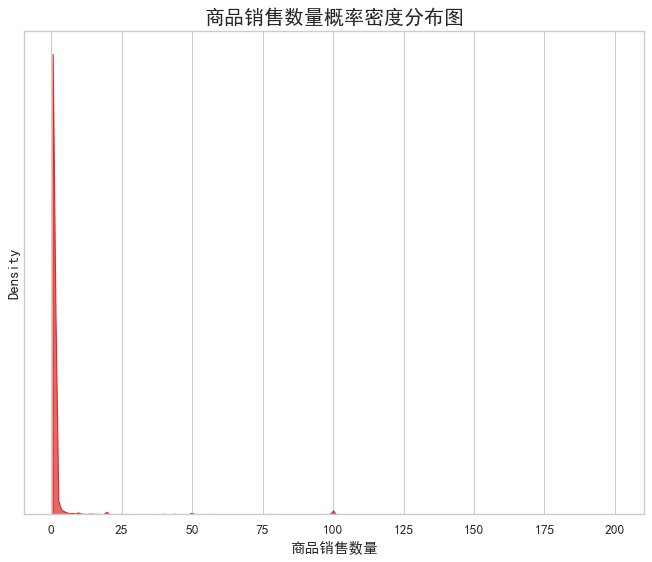

In [ ]:
plt.figure(figsize=(10, 8), dpi=80)
sns.kdeplot(data.loc[:, "商品销售数量"],
            shade=True,
            color="#dc2624",
            label="商品销售数量",
            alpha=.7)
#风格与装饰
sns.set(style="whitegrid",font="simhei", font_scale=1.1)
plt.title("商品销售数量概率密度分布图",fontsize=18)
plt.yticks([])
#plt.xlim((-1,20))
#plt.xlim((-1,5))
plt.show()

- 检测异常值：箱线图的法则
> **当任意样本的特定特征值超出 [QL-1.5\*IQR, QU+1.5*IQR]时，则认为该样本的该特征值是异常值**<br>
> QL:下四分位数，QU：上四分位数，IQR：QU-QL<br>

**为避免混淆，特征中存在异常值统称为“特征异常”，标签上标注为异常则成为“交易异常”**。以极度左偏的数据来看，特征异常的基本情况就是：一次性下单太多商品，或一次性支付太贵的金额，但这两点在电商实际业务中都是可能实现的。

In [ ]:
#进行异常值检测，并保存特征异常的样本的索引
NumOfSamples = data.shape[0]
DataNoAbnormal = data.copy()
BoxAbnormalIdx = [] #列表：用于保存特征异常的样本的索引
for idx,column in enumerate(["订单金额","商品销售数量"]):
    feature = data.loc[:,column]
    QL = np.quantile(feature,0.25)
    QU = np.quantile(feature,0.75)
    IQR = QU - QL
    #过小或过大的都属于异常值
    error = feature[((feature < (QL - 1.5*IQR)).astype(int) + (feature > (QU + 1.5*IQR)).astype(int)) != 0]
    BoxAbnormalIdx.extend(error.index)

In [ ]:
len(BoxAbnormalIdx)

31266

In [ ]:
BoxAbnormalIdx = set(BoxAbnormalIdx) #利用集合对筛选出的样本索引进行去重

In [ ]:
len(BoxAbnormalIdx) #没有太多重复，这说明大部分样本只有一个特征存在异常

29949

In [ ]:
len(BoxAbnormalIdx)/data.shape[0] #占总体样本的比例太高，无法直接删除

0.22812723754970216

In [ ]:
#特征异常的样本中，有多少被标记为交易异常？
(data.loc[BoxAbnormalIdx,"异常"] == 1).sum()

7368

考虑到所有交易异常加起来才接近3w，7000+其实是一个较大的数字，超过整体的1/4，因此特征异常样本不能直接删除，但特征的异常与交易的异常应该并无太直接的关系。我们可以按“是否有特征异常”构成新的特征，计算该特征与标签之间的相关性。

In [ ]:
df = pd.DataFrame(index=data.index)

In [ ]:
df["特征异常"] = 0

In [ ]:
df.loc[BoxAbnormalIdx,"特征异常"] = 1

In [ ]:
pd.concat([df["特征异常"],data["异常"]],axis=1).corr()

,特征异常,异常
特征异常,1.000000,0.040428
异常,0.040428,1.000000


看起来特征异常与实际交易异常之间几乎不存在任何关系，我们可以不使用这个特征。从电商业务角度来看，异常基本出现在用户支付大量金额、或一次性购入大量物品的时候，这些情况在电商交易流程中比较普遍，因此我们先不处理异常值，建模看看结果如何。

In [ ]:
data.head()

,订单ID,下单时间,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,异常
0,4283851335,14:09:49,手机摄影数码,POP,8002042497,三星,766000.0,200,主站,合并支付,dakehu_zy,上海市,1
1,4276537082,14:16:47,电视冰箱洗衣机空调,POP,8001992420,樱花,19900.0,100,主站,合并支付,qq-3be293b,泉州市,1
2,4281111595,10:44:46,家具建材,POP,8002199518,纬度空间,100.0,100,主站,合并支付,nonscorpio,广州市,1
3,3977175284,23:26:19,手机摄影数码,POP,8002237611,伊斯贝,990.0,100,主站,合并支付,swt6263122,宁德市,0
4,4106833871,16:47:34,家居日用,POP,8002212182,品道天元,8800.0,100,主站,合并支付,qq-edf69d7,深圳市,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
131277,4285755067,23:56:01,电视冰箱洗衣机空调,GO,1000296106,博世,2765.0,1,主站,货到付款,yanshuo3,北京市,0
131278,4285755076,23:57:24,电视冰箱洗衣机空调,GO,1000296108,西门子,2672.0,1,主站,货到付款,yanshuo3,北京市,0
131279,4285765029,23:54:34,家具建材,GO,1000348294,埃斯兰德,128.0,1,抢购,合并支付,1350304234,广州市,0
131280,4285770012,23:55:06,家居日用,GO,1000335947,炊大师,79.0,1,抢购,合并支付,shukun,东莞市,0


In [ ]:
data.to_csv(r'H:\精品课\sklearn实战案例\数据\电商异常检测\abnormal_order2.csv')